# Import Libraries

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# Load Dataset

In [ ]:
# Load dataset
df = pd.read_csv('balanced_dataset.csv')
df.head()

# Data Cleaning
# Drop duplicate rows
df = df.drop_duplicates()

# Handle missing values
df = df.dropna()

# Drop specified columns
df = df.drop(columns=['app_name', 'version_code', 'version_name'], errors='ignore')

# Convert labels into binary classes (0: Benign, 1: Malignant)
malware_labels = [0, 2, 3, 4]
df['label'] = df['label'].apply(lambda x: 1 if x in malware_labels else 0)

print(df.columns)

Index(['total_methods', 'file_size_kb', 'num_files', 'package_name',
       'num_receivers', 'num_intents', 'num_services', 'num_permissions',
       'num_activities', 'has_native_code', 'num_providers', 'label'],
      dtype='object')


In [466]:
categorical_columns = df.select_dtypes(include=['object']).columns.drop('label', errors='ignore')
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Display cleaned dataset
print("Cleaned Data:")
print(df.head())

corr_matrix = df.corr()
label_correlation = corr_matrix['label'].abs().sort_values(ascending=False)
top_features = ['total_methods','num_services','num_receivers','num_intents','num_files','num_permissions','num_activities','num_providers']  # Select top 5 correlated features
print("Top 5 Correlated Features:")
print(top_features)


X = df[top_features]
y = df['label']

# Display X and y before scaling
#print("Features (X) before scaling:")
#print(X.head())
print("Labels (y):")
print(y.head())

Cleaned Data:
   total_methods  file_size_kb  num_files  package_name  num_receivers  \
0          27872   4358.369141        105          1453              6   
1            661    100.318359         14          1909              3   
2          12012   3272.005859        257           909              0   
3              0  60780.087891       1341           956              2   
4           1178    616.455078         26          1053              2   

   num_intents  num_services  num_permissions  num_activities  \
0            2             2                8              11   
1            2             4               13               2   
2            2             5               18               9   
3            3             7               25               5   
4            2             1                9               4   

   has_native_code  num_providers  label  
0                1              1      1  
1                0              0      1  
2                1   

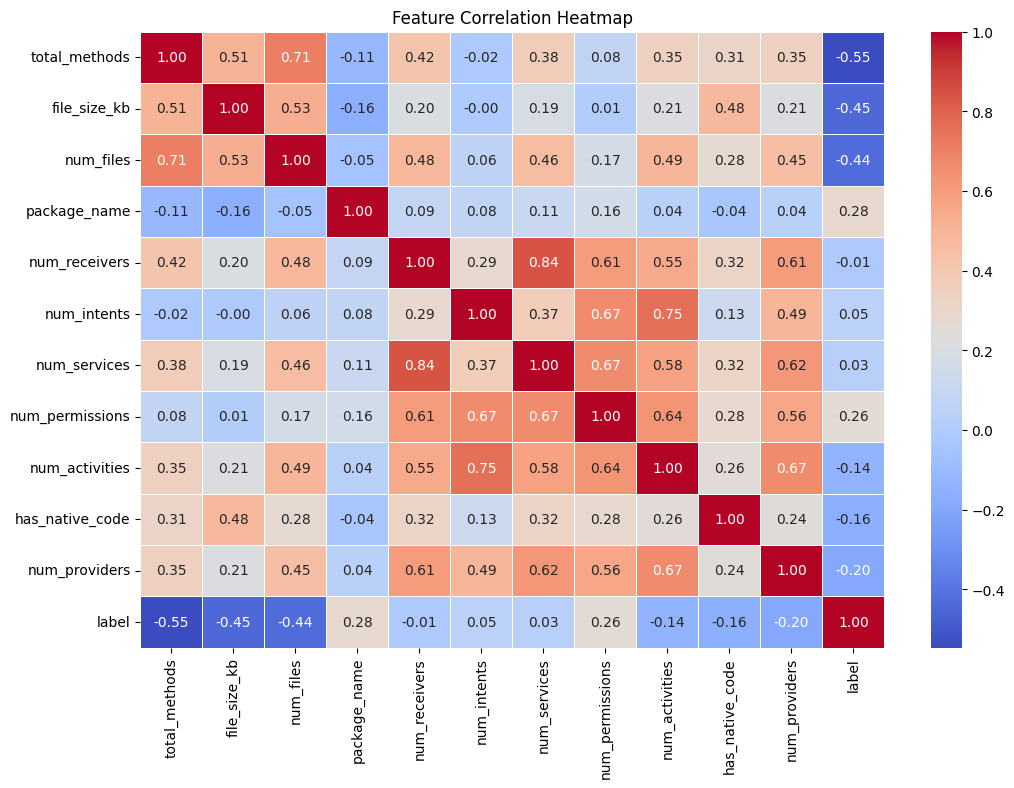

In [467]:
# Correlation Analysis
plt.figure(figsize=(12, 8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [469]:


# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display X_train and y_train
print("X_train:")
print(pd.DataFrame(X_train).head())
print("y_train:")
print(y_train.head())

X_train:
          0         1         2         3         4         5         6  \
0 -0.815901 -0.634865 -0.152823 -0.156529 -0.747973 -0.002672 -0.426358   
1  1.861163  0.928262  0.639901 -0.068742  0.213074 -0.190471  0.318239   
2  1.507234  1.397200  1.036263 -0.090688  0.244834  1.562322  0.169319   
3  0.278629 -0.165927  0.838082 -0.090688  0.700067 -0.065271 -0.366790   
4  0.232234  2.491388  1.828988 -0.112635 -0.690333  0.498126 -0.188087   

          7  
0 -0.416101  
1  1.009679  
2  0.296789  
3 -0.416101  
4  0.296789  
y_train:
2239    1
1171    0
1449    1
881     0
2029    1
Name: label, dtype: int64


# Model Shiz

In [473]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Apply Fuzzy C-Means Clustering with tuned hyperparameters
cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
    X_train.T, 2, 2, error=0.00001, maxiter=10000, init=None, seed=42
)

# Assign labels based on maximum membership values
cluster_labels = np.argmax(u, axis=0)

# Ensure cluster_labels matches the training set size
cluster_labels = cluster_labels[:len(y_train)]

# Convert cluster labels to match malware classification (0: Benign, 1: Malignant)
if np.mean(y_train.iloc[cluster_labels == 0]) > np.mean(y_train.iloc[cluster_labels == 1]):
    cluster_labels = np.where(cluster_labels == 0, 1, 0)

# Evaluate model performance
conf_matrix = confusion_matrix(y_test, cluster_labels[:len(y_test)])
print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, cluster_labels[:len(y_test)]))


Confusion Matrix:
 [[ 57 192]
 [ 62 167]]

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.23      0.31       249
           1       0.47      0.73      0.57       229

    accuracy                           0.47       478
   macro avg       0.47      0.48      0.44       478
weighted avg       0.47      0.47      0.43       478



# Visualization

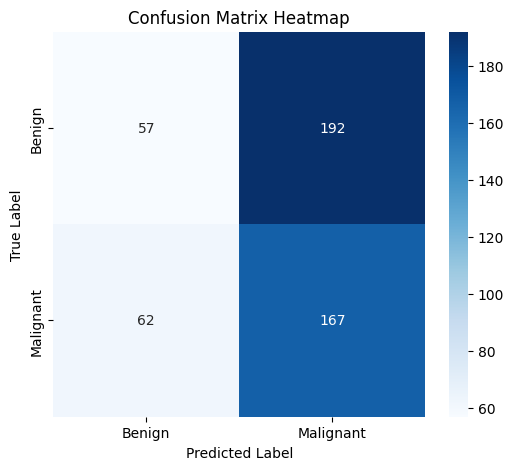

In [459]:
# Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix Heatmap")
plt.show()


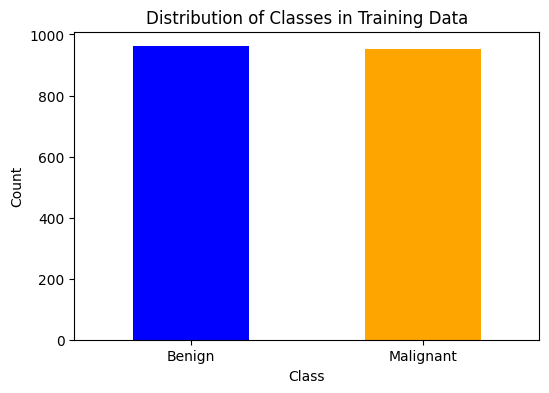

In [460]:
# Bar Chart Visualization of Class Distribution
plt.figure(figsize=(6, 4))
y_train.value_counts().plot(kind='bar', color=['blue', 'orange'])
plt.xticks(ticks=[0, 1], labels=['Benign', 'Malignant'], rotation=0)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Distribution of Classes in Training Data")
plt.show()